In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/weather-dataset/weatherHistory.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
#perla sami younane 320220028
#nihal ahmed adly 320220039

2025-05-20 20:00:31.307347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747771231.580665      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747771231.656898      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv("/kaggle/input/weather-dataset/weatherHistory.csv")
df.head()


,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [4]:
print(df.isnull().sum())
df = df.fillna(method="ffill")  # Forward fill missing values


Formatted Date                0
Summary                       0
Precip Type                 517
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64


/tmp/ipykernel_35/4075862900.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill")  # Forward fill missing values


In [5]:
print(df.isnull().sum())

Formatted Date              0
Summary                     0
Precip Type                 0
Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Loud Cover                  0
Pressure (millibars)        0
Daily Summary               0
dtype: int64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


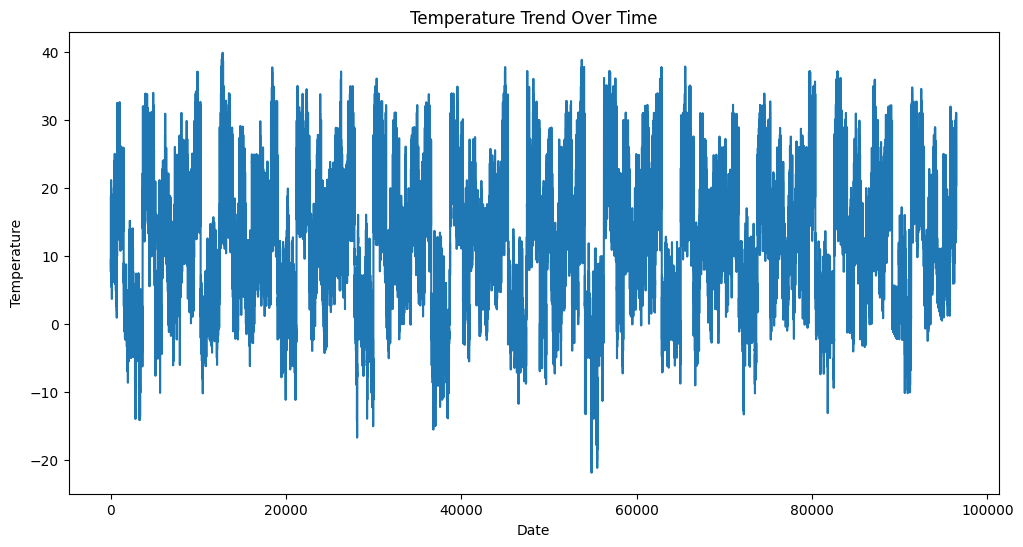

In [6]:
plt.figure(figsize=(12, 6))
# The column name likely has an extra space at the end. Remove it.
sns.lineplot(x=df.index, y=df["Temperature (C)"])
plt.title("Temperature Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.show()

In [7]:
features = ["Temperature (C)", "Humidity", "Wind Speed (km/h)"]  # Use actual column names from the DataFrame
df = df[features]

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

In [8]:
def create_sequences_multi(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])  # Predict all 3 features at once
    return np.array(X), np.array(y)

# Define the sequence length - you can adjust this value
seq_length = 30

X, y = create_sequences_multi(df_scaled, seq_length)

In [9]:
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]


In [10]:
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model

input_layer = Input(shape=(seq_length, len(features)))

lstm_layer = LSTM(64, return_sequences=True)(input_layer)
lstm_layer = LSTM(32)(lstm_layer)

# Output layer with 3 units (one per feature)
output_layer = Dense(len(features), activation='linear')(lstm_layer)

model_multi = Model(inputs=input_layer, outputs=output_layer)

model_multi.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_multi.summary()
history_multi = model_multi.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


2025-05-20 20:01:55.634727: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30, 3)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 30, 64)              │          17,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,923 (116.89 KB)

 Trainable params: 29,923 (116.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 55s 21ms/step - loss: 0.0109 - mae: 0.0659 - val_loss: 0.0020 - val_mae: 0.0311
Epoch 2/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step - loss: 0.0025 - mae: 0.0343 - val_loss: 0.0019 - val_mae: 0.0293
Epoch 3/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step - loss: 0.0024 - mae: 0.0332 - val_loss: 0.0019 - val_mae: 0.0292
Epoch 4/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 51s 21ms/step - loss: 0.0023 - mae: 0.0327 - val_loss: 0.0018 - val_mae: 0.0274
Epoch 5/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 51s 21ms/step - loss: 0.0023 - mae: 0.0324 - val_loss: 0.0018 - val_mae: 0.0289
Epoch 6/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 51s 21ms/step - loss: 0.0023 - mae: 0.0323 - val_loss: 0.0018 - val_mae: 0.0291
Epoch 7/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 51s 21ms/step - loss: 0.0023 - mae: 0.0321 - val_loss: 0.0018 - val_mae: 0.0286
Epoch 8/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 51s 21ms/step - loss: 0.0023 - mae: 0.0321 - val_loss: 0.0018 - val_mae: 0.0282
Epoch 9/20
2411/2411 ━━━

In [11]:
y_pred_multi = model_multi.predict(X_test)

# Inverse scale all features at once (no need for padding zeros now)
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred_multi)



mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")




603/603 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
MAE: 1.03, RMSE: 2.01


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Temperature evaluation (index 0)
mae_temp = mean_absolute_error(y_test_inv[:, 0], y_pred_inv[:, 0])
rmse_temp = np.sqrt(mean_squared_error(y_test_inv[:, 0], y_pred_inv[:, 0]))
print(f"Temperature - MAE: {mae_temp:.2f}, RMSE: {rmse_temp:.2f}")

# Similarly for Humidity (index 1)
mae_hum = mean_absolute_error(y_test_inv[:, 1], y_pred_inv[:, 1])
rmse_hum = np.sqrt(mean_squared_error(y_test_inv[:, 1], y_pred_inv[:, 1]))
print(f"Humidity - MAE: {mae_hum:.2f}, RMSE: {rmse_hum:.2f}")

# And for Wind Speed (index 2)
mae_wind = mean_absolute_error(y_test_inv[:, 2], y_pred_inv[:, 2])
rmse_wind = np.sqrt(mean_squared_error(y_test_inv[:, 2], y_pred_inv[:, 2]))
print(f"Wind Speed - MAE: {mae_wind:.2f}, RMSE: {rmse_wind:.2f}")


Temperature - MAE: 0.67, RMSE: 1.05
Humidity - MAE: 0.03, RMSE: 0.05
Wind Speed - MAE: 2.40, RMSE: 3.32


In [13]:
# Ensure mae_temperature, mae_humidity, and mae_wind_speed are defined from previous cells.
# Ensure y_test_inv is available from previous cells.

# Calculate the range for each feature in the test set
range_temperature = np.max(y_test_inv[:, 0]) - np.min(y_test_inv[:, 0])
range_humidity = np.max(y_test_inv[:, 1]) - np.min(y_test_inv[:, 1])
range_wind_speed = np.max(y_test_inv[:, 2]) - np.min(y_test_inv[:, 2])

# Use the correct variable names mae_temp, mae_hum, mae_wind
acc_temperature = (1 - mae_temp / range_temperature) * 100
acc_humidity = (1 - mae_hum / range_humidity) * 100
acc_wind_speed = (1 - mae_wind / range_wind_speed) * 100

# Average accuracy
average_accuracy = (acc_temperature + acc_humidity + acc_wind_speed)/3
# Print results
print(f"Temperature Accuracy: {acc_temperature:.2f}%")
print(f"Humidity Accuracy: {acc_humidity:.2f}%")
print(f"Wind Speed Accuracy: {acc_wind_speed:.2f}%")
print(f"\nAverage Accuracy: {average_accuracy:.2f}%")

Temperature Accuracy: 98.67%
Humidity Accuracy: 95.97%
Wind Speed Accuracy: 94.86%

Average Accuracy: 96.50%


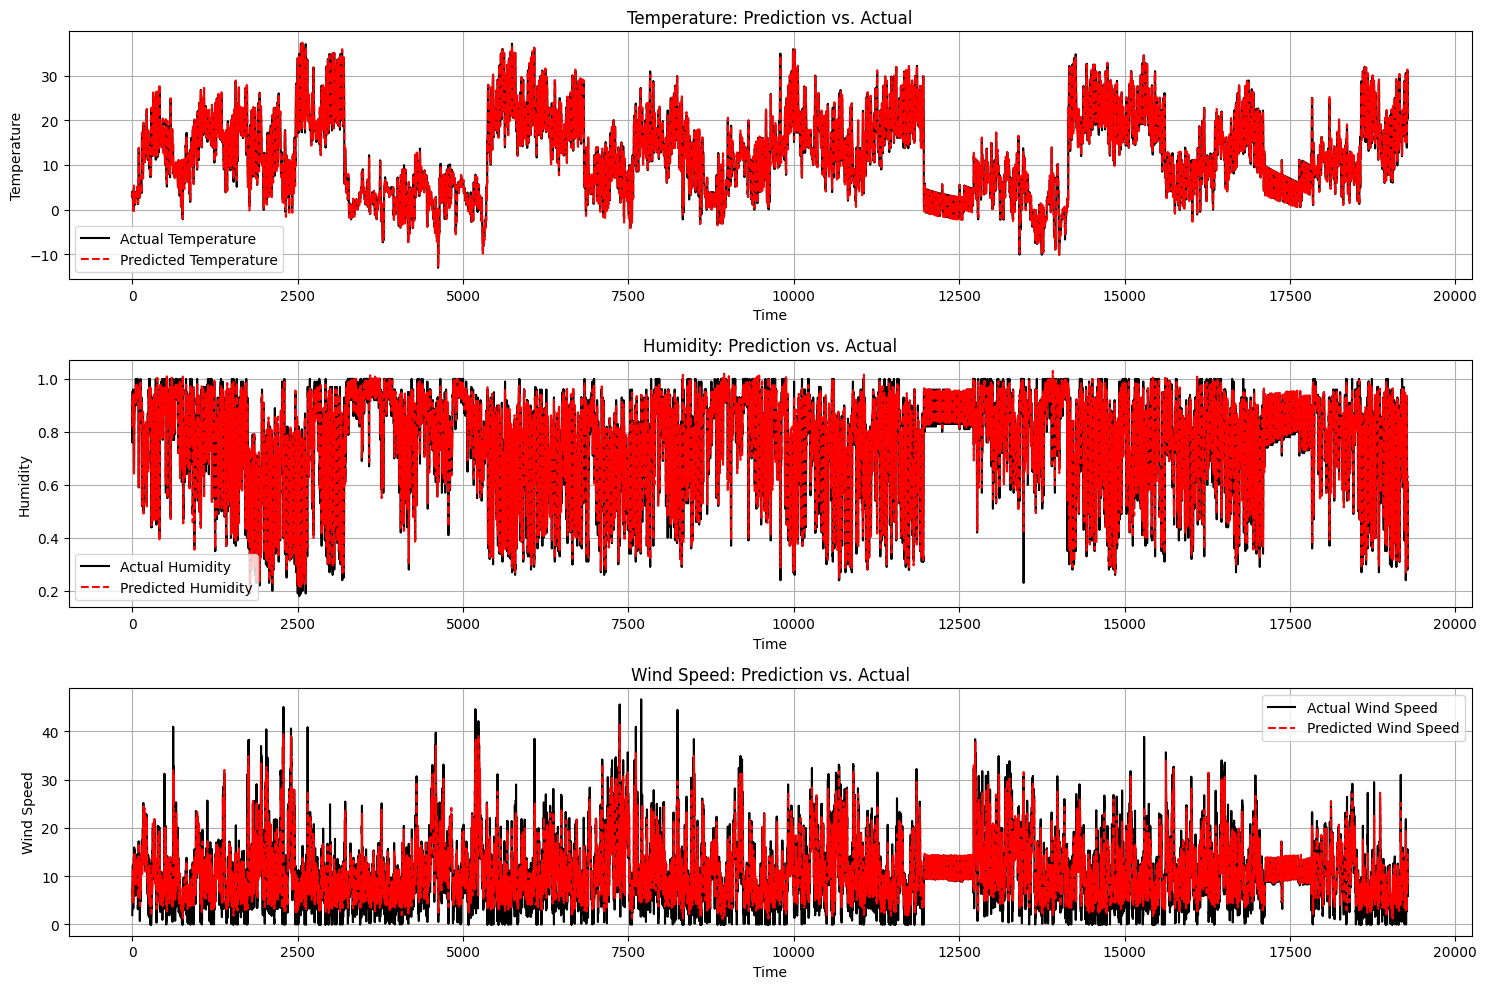

In [14]:
import matplotlib.pyplot as plt

# Feature names (match the order used in inverse transform)
features = ['Temperature', 'Humidity', 'Wind Speed']

# Create subplots
plt.figure(figsize=(15, 10))

for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(y_test_inv[:, i], label=f"Actual {features[i]}", color="black")
    plt.plot(y_pred_inv[:, i], label=f"Predicted {features[i]}", linestyle="dashed", color="red")
    plt.xlabel("Time")
    plt.ylabel(features[i])
    plt.title(f"{features[i]}: Prediction vs. Actual")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [15]:
future_steps = 7  # Predict for the next 7 days
future_preds_all = []  # Store predictions for all 3 features

# Start with the last known input sequence
current_input = X_test[-1].reshape(1, seq_length, len(features))

for _ in range(future_steps):
    # Predict the next time step for all 3 features
    pred_all = model_multi.predict(current_input)[0]  # Shape: (3,)
    future_preds_all.append(pred_all)

    # Shift input sequence left and append prediction
    new_input = np.roll(current_input, -1, axis=1)
    new_input[0, -1, :] = pred_all  # Insert all predicted features
    current_input = new_input

# Convert predictions back to original scale (inverse transform)
future_preds_all = np.array(future_preds_all)  # Shape: (7, 3)
# Inverse transform the 3 predicted features
future_preds_all_inv = scaler.inverse_transform(future_preds_all)

# Print predictions nicely
print("Predicted Weather for the Next 7 Days:")
for i in range(future_steps):
    temp, hum, wind = future_preds_all_inv[i]
    print(f"Day {i+1}: Temp = {temp:.2f}°C, Humidity = {hum:.2f}, Wind Speed = {wind:.2f} km/h")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted Weather for the Next 7 Days:
Day 1: Temp = 21.02°C, Humidity = 0.63, Wind Speed = 9.95 km/h
Day 2: Temp = 20.34°C, Humidity = 0.67, Wind Speed = 9.45 km/h
Day 3: Temp = 19.58°C, Humidity = 0.71, Wind Speed = 8.82 km/h
Day 4: Temp = 18.98°C, Humidity = 0.75, Wind Speed = 8.26 km/h
Day 5: Temp = 18.55°C, Humidity = 0.78, Wind Speed = 7.91 km/h
Day 6: Temp = 18.11°C, Humidity = 0.80, Wind Speed = 7.66 km/h
Day 7: Temp = 17.60°C, Humidity = 0.83, Wind Speed = 7.36 km/h


In [17]:
# Save the entire model (architecture + weights + optimizer state)
# Replace 'model' with the correct model variable name (model_multi or model_gru)
model_multi.save("lstm_weather_model.h5")  # Saves in HDF5 format

In [18]:
from tensorflow.keras.layers import GRU

model_gru = Sequential([
    GRU(64, return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    GRU(32, return_sequences=False),
    Dense(16, activation="relu"),
    Dense(1)
])

model_gru.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
model_gru.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 30, 64)              │          13,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,201 (90.63 KB)

 Trainable params: 23,201 (90.63 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history_gru = model_gru.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 69s 26ms/step - loss: 0.0791 - val_loss: 0.0798
Epoch 2/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 61s 25ms/step - loss: 0.0770 - val_loss: 0.0798
Epoch 3/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 58s 24ms/step - loss: 0.0771 - val_loss: 0.0797
Epoch 4/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 57s 24ms/step - loss: 0.0771 - val_loss: 0.0797
Epoch 5/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 60s 25ms/step - loss: 0.0768 - val_loss: 0.0798
Epoch 6/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 58s 24ms/step - loss: 0.0768 - val_loss: 0.0797
Epoch 7/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 60s 25ms/step - loss: 0.0771 - val_loss: 0.0798
Epoch 8/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 63s 26ms/step - loss: 0.0769 - val_loss: 0.0797
Epoch 9/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 60s 25ms/step - loss: 0.0769 - val_loss: 0.0797
Epoch 10/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 60s 25ms/step - loss: 0.0768 - val_loss: 0.0797
Epoch 11/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 58s 24ms/step - loss: 0.0770 - val_loss: 0.0797
Epoch 12

In [20]:
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
# Ensure features and seq_length are defined (from previous cells)
# features = ["Temperature (C)", "Humidity", "Wind Speed (km/h)"]
# seq_length = 30

model_gru = Sequential([
    GRU(64, return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    GRU(32, return_sequences=False),
    # Change the output layer to predict all 3 features
    Dense(len(features), activation='linear')
])

model_gru.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
model_gru.summary()

# Ensure X_train, y_train, X_test, y_test are available from previous cells
# history_gru = model_gru.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

y_pred_gru = model_gru.predict(X_test)

# Inverse scale all features at once - remove the slicing
y_pred_gru_inv = scaler.inverse_transform(y_pred_gru)

# Ensure y_test_inv is available from the LSTM section (inverse transformed y_test)
# y_test_inv = scaler.inverse_transform(y_test)

# Calculate metrics using the corrected y_pred_gru_inv
mae_gru = mean_absolute_error(y_test_inv, y_pred_gru_inv)
rmse_gru = np.sqrt(mean_squared_error(y_test_inv, y_pred_gru_inv))

print(f"GRU Model - MAE: {mae_gru:.2f}, RMSE: {rmse_gru:.2f}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                          │ (None, 30, 64)              │          13,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,755 (88.89 KB)

 Trainable params: 22,755 (88.89 KB)

 Non-trainable params: 0 (0.00 B)

603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
GRU Model - MAE: 13.14, RMSE: 19.12


In [21]:
import numpy as np

future_steps = 7  # Predict next 7 days
future_preds_gru = []  # Store predictions for 3 features

# Start with the last known input sequence
current_input = X_test[-1].reshape(1, seq_length, X_test.shape[2])  # Shape: (1, seq_len, 3)

for _ in range(future_steps):
    # Predict the next day's 3 features
    pred = model_gru.predict(current_input)[0]  # Shape: (3,)
    future_preds_gru.append(pred)

    # Shift the input window and append the new prediction
    new_input = np.roll(current_input, -1, axis=1)
    new_input[0, -1, :] = pred  # Replace the last time step with the prediction
    current_input = new_input

# Convert predictions back to original scale
future_preds_gru = np.array(future_preds_gru)
# If your scaler was fit on all features, pad the prediction to fit that shape
padded_preds = np.concatenate([future_preds_gru, np.zeros((future_preds_gru.shape[0], scaler.n_features_in_ - 3))], axis=1)
future_preds_gru_inv = scaler.inverse_transform(padded_preds)[:, :3]  # Get only the 3 predicted features

# Print Results
print("GRU - Predicted Weather for the Next 7 Days:")
for i in range(future_steps):
    temp, hum, wind = future_preds_gru_inv[i]
    print(f"Day {i+1}: Temp = {temp:.2f}°C | Humidity = {hum:.2f} | Wind Speed = {wind:.2f} km/h")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
GRU - Predicted Weather for the Next 7 Days:
Day 1: Temp = -17.15°C | Humidity = 0.01 | Wind Speed = 1.09 km/h
Day 2: Temp = -18.29°C | Humidity = 0.01 | Wind Speed = 0.71 km/h
Day 3: Temp = -19.24°C | Humidity = 0.01 | Wind Speed = 0.44 km/h
Day 4: Temp = -19.87°C | Humidity = 0.01 | Wind Speed = 0.37 km/h
Day 5: Temp = -20.27°C | Humidity = 0.00 | Wind Speed = 0.39 km/h
Day 6: Temp = -20.57°C | Humidity = 0.00 | Wind Speed = 0.42 km/h
Day 7: Temp = -20.80°C | Humidity = 0.00 | Wind Speed = 0.41 km/h


In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Compute MAE, RMSE, and R² Score for LSTM
mae_lstm = mean_absolute_error(y_test_inv, y_pred_inv)
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2_lstm = r2_score(y_test_inv, y_pred_inv)

# Compute MAE, RMSE, and R² Score for GRU
mae_gru = mean_absolute_error(y_test_inv, y_pred_gru_inv)
rmse_gru = np.sqrt(mean_squared_error(y_test_inv, y_pred_gru_inv))
r2_gru = r2_score(y_test_inv, y_pred_gru_inv)

# Print comparison
print("📊 Numerical Comparison of LSTM vs. GRU")
print(f"LSTM - MAE: {mae_lstm:.3f}, RMSE: {rmse_lstm:.3f}, R²: {r2_lstm:.3f}")
print(f"GRU  - MAE: {mae_gru:.3f}, RMSE: {rmse_gru:.3f}, R²: {r2_gru:.3f}")


📊 Numerical Comparison of LSTM vs. GRU
LSTM - MAE: 1.033, RMSE: 2.013, R²: 0.890
GRU  - MAE: 13.138, RMSE: 19.118, R²: -9.864
